In [19]:
import pandas as pd

In [20]:

df = pd.read_csv('sab-bma.csv')


In [21]:
df


,Refs,Reads
0,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCTCCATGCGCGT...,ACCATAATGCGTGGGGCCGACCTCGGAATGCGGTCATACGCGGCTC...
1,TCGAAGCAGTAGGGCCTACCAAATAGGTTGGTCCTCCGTTGTATCT...,TCGAAGCAGTAGGGCCTACAAATAGGTTGGTCCTCCGTTCTATCTA...
2,AGTTAACGTCCCACGGCGAGGCACTCTTGATCCCCACCTTCAAGAG...,AGTTAAACCCCACGCAGGAGCTCTAGGATACCCACCTGCAAGAGGT...
3,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAGCGCGT...,GCCCAAGGGTACGCCCGCAGCGACGCAATTGGCGGAGTAAAGCGTG...
4,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCCATTTTGT...,GCACTGATGTAACTCATGGTACATCCGTCGCTGAGCGCATGTTTTG...
...,...,...
9995,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...,GCATGATTTGGAAGGTCGGCACTATACCCACCCAGGGTATATGGTC...
9996,GAAGTTTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTTCTAGTA...,GAAATTGGAACGTGTTCGTCCGCCAATTAAGGTTGGCTCTCTAATA...
9997,TGCATCCCGGACAACCGCAAGGGTGCATGGGCACCGCAATTCCCAA...,TGCATCCCGGACAACCGCAAGGGTGCATGGCACCGCATTCCCAATT...
9998,ACTGGACGTCCTATGCTGGCATAATGAAACGACAACCTGTCTTCGA...,ACTGGACGTCCTATGCTGCATAATGAAACGACAACCTGTCTTGACT...


In [22]:
from tqdm import tqdm


In [23]:
noisy_strands = [s.strip() for s in list(df['Reads'])]


In [24]:
ref_strands = [s.strip() for s in list(df['Refs'])]


In [25]:
import difflib


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import os

# use LaTeX fonts in the plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2021basic/bin/universal-darwin'

In [27]:
def print_diff(ref_strand, noisy_strand):
    global pairs
    global pairs_no_pos
    a, b = 0, 0

    # quadratic time, no heuristics
    for match in difflib.SequenceMatcher(None, ref_strand, noisy_strand, autojunk=False).get_matching_blocks():
        was = ref_strand[a:match.a]
        now = noisy_strand[b:match.b]
        
        a = match.a + match.size
        b = match.b + match.size
        
        if was == '' and now == '':
            pass
        else:
            # print('{}|{}'.format(was, now), end=', ')
            pairs += [(was, now, match.a)]
            pairs_no_pos += [(was, now)]



100%|██████████| 10000/10000 [00:00<00:00, 81399.49it/s]


[88, 268, 416, 606, 785, 987, 1159, 1331, 1516, 1702, 1849, 2061, 2232, 2307, 2527, 2613, 2764, 2915, 3058, 3160, 3285, 3397, 3505, 3608, 3680, 3872, 3943, 3986, 4139, 4218, 4297, 4292, 4478, 4518, 4565, 4617, 4707, 4668, 4789, 4948, 4949, 5008, 5118, 5087, 5252, 5151, 5207, 5213, 5236, 5395, 5384, 5360, 5303, 5548, 5448, 5566, 5473, 5473, 5411, 5366, 5482, 5239, 5272, 5213, 5140, 5092, 5021, 4958, 4972, 4942, 4911, 4815, 4771, 4738, 4580, 4497, 4435, 4401, 4337, 4168, 4194, 4037, 3976, 3869, 3779, 3669, 3564, 3507, 3368, 3204, 3103, 2963, 2838, 2739, 2612, 2477, 2333, 2179, 2040, 1810, 1618, 1543, 1314, 1139, 958, 770, 574, 378, 213, 48]


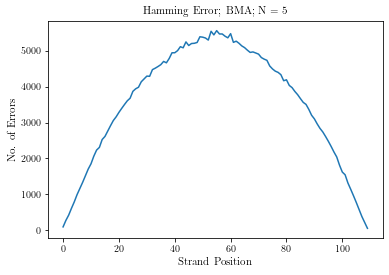

In [28]:
# Hamming Distance Graph
strand_len = 110
count_pos = [0] * (strand_len + 1)

def hamming(ref_strand, recons_strand):
    for i, (c1, c2) in enumerate(zip(ref_strand, recons_strand)):
        if c1 != c2:
            count_pos[i] += 1

for i in tqdm(range(len(ref_strands))):
    hamming(ref_strands[i], noisy_strands[i])

print(count_pos[:-1])
f = plt.figure()
plt.plot(range(strand_len), count_pos[:-1])
plt.title(r'Hamming Error; BMA; N = 5', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov5-sab-bma-hamming.pdf', bbox_inches='tight')

In [29]:
pairs = []
pairs_no_pos = []

for i in tqdm(range(len(ref_strands))):
    if ref_strands[i] != noisy_strands[i]:
        print_diff(ref_strands[i], noisy_strands[i])


100%|██████████| 10000/10000 [00:12<00:00, 789.54it/s]


In [30]:

subs_no_pos, counts_no_pos = np.unique(pairs_no_pos, return_counts=True, axis=0)
sorting = np.argsort(counts_no_pos)
subs_no_pos = subs_no_pos[sorting]
counts_no_pos = counts_no_pos[sorting]

for sub, count in zip(subs_no_pos, counts_no_pos):
    if count > 5:
        print("{} -> {}".format(sub[0], sub[1]), count)


 -> GGAG 6
 -> GGAC 6
TG -> AAC 6
 -> GACC 6
 -> AGAGA 6
 -> AGGA 6
T -> AACA 6
 -> CAAG 6
G -> ACCC 6
TCCT ->  6
 -> GCCA 6
 -> AGCG 6
G -> CAAA 6
CCTA ->  6
 -> ATCA 6
 -> GATG 6
TGAC ->  6
T -> ACAC 6
GGGT ->  6
 -> ATAC 6
G -> TAA 6
C -> AGT 6
T -> ACC 6
TCTT ->  6
GGTA ->  6
CC -> GA 6
CC -> T 6
GGT -> C 6
TC -> AAA 6
 -> CAAC 6
CT -> GG 6
 -> TCAC 6
 -> CGAC 6
AGCT ->  6
GCCT ->  6
 -> AACT 6
 -> CGGC 6
TTGT ->  6
AT -> GC 6
TTGA ->  6
GG -> TA 6
AG -> CC 6
 -> ACACA 6
 -> CCAG 6
 -> CGCC 6
AGT -> C 6
TAG -> C 6
 -> AAAT 6
 -> TATA 6
TTGG ->  6
 -> CCGG 6
ACA ->  6
TGCG ->  6
ATT -> G 6
 -> TACA 6
CTAT ->  6
 -> ACGG 6
 -> CCTA 6
T -> AGAC 6
 -> ACTC 6
CGGT ->  6
T -> GCC 6
T -> GAG 6
TC -> GG 6
GAGT ->  6
 -> AAGG 7
 -> AATC 7
CTTG ->  7
 -> AGAC 7
 -> AATA 7
G -> CACA 7
TGAA ->  7
AATT ->  7
 -> AAGC 7
TGG -> C 7
 -> GATA 7
CT -> AAA 7
 -> CCCC 7
TCTG ->  7
GCGT ->  7
 -> CCGA 7
GTTG ->  7
 -> CTAC 7
TGTT ->  7
TATT ->  7
TAGG ->  7
 -> ACGC 7
 -> CAGA 7
TG -> CAC 7
CTGC ->  7


G -> AA @ 56 6
AG ->  @ 56 6
CT ->  @ 48 6
GA ->  @ 39 6
C -> G @ 20 6
T -> AC @ 60 6
 -> GC @ 48 6
TT ->  @ 59 6
 -> AAC @ 54 6
 -> GC @ 59 6
CT ->  @ 33 6
GA ->  @ 56 6
A -> C @ 40 6
C -> G @ 76 6
C -> G @ 75 6
A -> C @ 37 6
 -> AA @ 61 6
A -> C @ 33 6
TT -> C @ 57 6
AT ->  @ 80 6
G -> A @ 109 6
 -> AA @ 39 6
GC ->  @ 61 6
GT ->  @ 91 6
T -> AA @ 22 6
 -> CA @ 52 6
TT ->  @ 62 6
A -> C @ 26 6
C -> G @ 71 6
A -> C @ 24 6
 -> AT @ 50 6
 -> GC @ 58 6
A -> C @ 27 6
AT ->  @ 99 6
GT ->  @ 27 6
 -> GA @ 64 6
CT ->  @ 72 6
CT ->  @ 73 6
C -> G @ 31 6
G -> T @ 62 6
CT ->  @ 77 6
G -> T @ 88 6
AG ->  @ 62 6
G -> T @ 63 6
 -> ACA @ 53 6
A -> C @ 41 6
CT ->  @ 22 6
 -> GA @ 50 6
 -> CA @ 21 6
C -> T @ 96 6
AG ->  @ 82 6
TT ->  @ 67 6
G -> T @ 67 6
AC ->  @ 57 6
C -> G @ 42 6
GT ->  @ 19 6
G -> T @ 69 6
C -> G @ 45 6
 -> ACC @ 56 6
 -> GG @ 58 6
GT ->  @ 12 6
GT ->  @ 25 6
GT ->  @ 26 6
C -> G @ 60 6
G -> T @ 52 6
T -> AA @ 46 6
G -> T @ 54 6
G -> T @ 55 6
 -> AG @ 58 6
C -> G @ 57 6
CT ->  @ 61

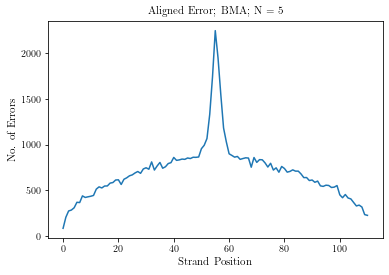

In [31]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]

for sub, count in zip(subs, counts):
    if count > 5:
        print("{} -> {} @ {}".format(sub[0], sub[1], sub[2]), count)

strand_len = 110
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    pos_counts[int(sub[2])] += count

print(pos_counts)

f = plt.figure()
plt.plot(range(strand_len + 1), pos_counts)
plt.title(r'Aligned Error; BMA; N = 5', fontsize=11)
plt.xlabel(r'Strand Position', fontsize=11)
plt.ylabel(r'No. of Errors', fontsize=11)
plt.show()
f.savefig('cov5-sab-bma-aligned.pdf', bbox_inches='tight')

In [32]:
subs, counts = np.unique(pairs, return_counts=True, axis=0)
sorting = np.argsort(counts)
subs = subs[sorting]
counts = counts[sorting]


In [33]:
def get_key(char1, char2):
    char1 = char1 if char1 != '' else '_'
    char2 = char2 if char2 != '' else '_'
    return char1 + ' -> ' + char2

strand_len = 110
pos_map = {}
pos_counts = [0] * (strand_len + 1)
for sub, count in zip(subs, counts):
    key = get_key(sub[0], sub[1])
    if key not in pos_map:
        pos_map[key] = [0] * (strand_len + 1)
    pos_map[key][int(sub[2])] += count

In [34]:
sub_keys = [get_key(sub[0], sub[1]) for sub in subs_no_pos]
max_10_keys = sub_keys[-10:]
max_10_counts = counts_no_pos[-10:]


[0, 42, 43, 37, 45, 54, 61, 62, 50, 37, 67, 52, 54, 50, 71, 68, 86, 67, 62, 81, 82, 66, 74, 72, 69, 66, 89, 81, 71, 81, 84, 71, 77, 79, 74, 97, 81, 70, 68, 90, 87, 70, 79, 74, 72, 97, 78, 83, 73, 71, 76, 86, 73, 82, 83, 101, 91, 84, 65, 66, 76, 65, 75, 79, 79, 90, 84, 83, 69, 79, 87, 77, 75, 73, 80, 82, 69, 83, 68, 87, 67, 76, 62, 89, 84, 81, 74, 72, 78, 66, 52, 63, 75, 76, 56, 57, 60, 68, 76, 73, 54, 55, 45, 43, 49, 56, 44, 45, 68, 55, 41]
[33, 33, 40, 37, 32, 43, 35, 53, 50, 44, 49, 52, 53, 64, 61, 49, 55, 40, 55, 66, 57, 48, 52, 64, 72, 83, 63, 77, 68, 72, 62, 63, 77, 67, 69, 79, 72, 77, 66, 62, 70, 87, 84, 68, 64, 66, 60, 76, 68, 70, 63, 81, 75, 89, 140, 184, 143, 100, 77, 83, 91, 84, 68, 74, 72, 74, 76, 76, 68, 82, 75, 75, 69, 76, 67, 70, 75, 72, 68, 74, 63, 56, 71, 74, 53, 80, 61, 67, 65, 54, 54, 52, 59, 43, 57, 46, 42, 50, 65, 65, 52, 40, 44, 27, 40, 47, 32, 38, 40, 20, 12]
[0, 37, 25, 40, 40, 43, 40, 54, 45, 58, 42, 36, 43, 58, 43, 50, 54, 56, 55, 45, 40, 45, 62, 51, 66, 44, 54

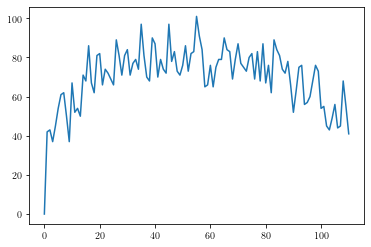

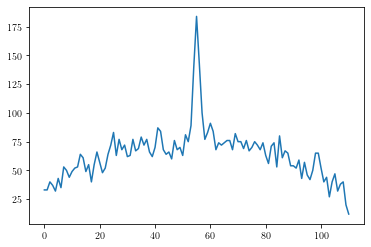

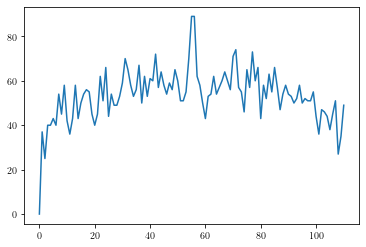

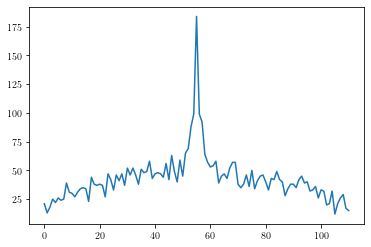

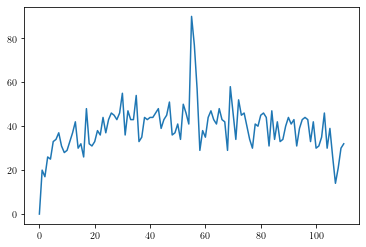

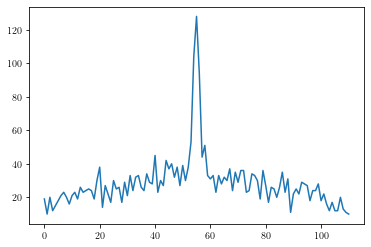

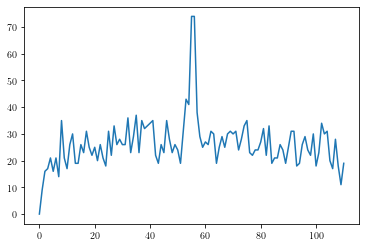

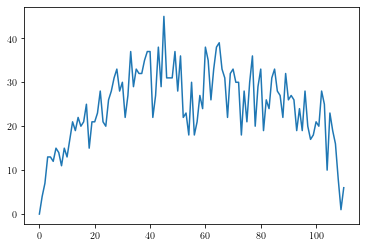

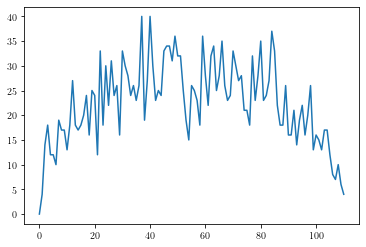

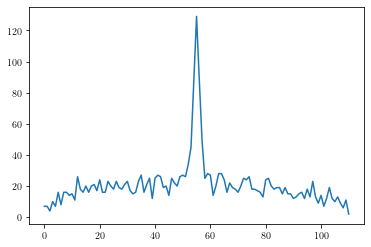

In [35]:
for key, count in zip(reversed(max_10_keys), reversed(max_10_counts)):
    plt.figure(key)
    print(pos_map[key])
    plt.plot(range(strand_len + 1), pos_map[key])

In [36]:
np.save('subs.npy', subs)
np.save('counts.npy', counts)